<a href="https://colab.research.google.com/github/santiagoahl/analisis-contratos-gov/blob/main/contratos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Análisis de contratos en gobernaciones municipales de Colombia](#scrollTo=jNom8OrMyqbH)

>>[Propósito](#scrollTo=jNom8OrMyqbH)

>>[Metodología](#scrollTo=jNom8OrMyqbH)

>>[WIP - Futuras mejoras](#scrollTo=jNom8OrMyqbH)

>[Librerías](#scrollTo=0T1F1SipyqbM)

>[Importando los datos](#scrollTo=VfQChYzEyqbR)

>>[Limpieza de datos](#scrollTo=LEw27hTHdMRO)

>[Data Viz](#scrollTo=8-mxHFYN1PdJ)

>[Análisis de texto](#scrollTo=R3xJYmZBPSw0)

>[Modelamiento](#scrollTo=n8U6Mv_cgx-3)

>>[Aprendizaje supervisado: Predicción de valor de contrato](#scrollTo=z36JN0rFhGCW)

>>[No supervisado: Agrupamiento de texto](#scrollTo=IpzLumMqhINy)

>>[No supervisado: para detección de anomalías](#scrollTo=l_Zr32VbhMTC)



# Análisis de contratos en gobernaciones municipales de Colombia

*contratos.ipynb*

## Propósito
Dar seguimiento al manejo de recursos públicos por parte de gobernaciones municipales. Agrupar dichos gastos, encontrar palabras claves y detectar gastos anómalos. 

## Metodología
Tomamos los datos del reporte del Sistema Electrónico para la Contratación Pública [SECOP Integrado | Gastos gubernamentales](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-Integrado/rpmr-utcd). Analizamos la información, limpiamos los datos y escogimos los datos relevantes para nuestro objetivo. Luego procedimos a entrenar tres modelos de aprendizaje automático:
- `RandomForestRegressor`: Estimador de valor de los contratos celebrados.
- `LDA` (Latent Dirichlet Allocation): Técnica de procesamiento de lenguaje natural para agrupamiento de texto.
- `scipy.stats.norm`: Detección de datos anómalos con base en la distribución de Gauss.

## WIP - Futuras mejoras

Notable TODOs:
- Normalización de datos previo al entrenamiento de `RandomForestRegressor`;
- Despliegue del modelo mediante una API REST con FastAPI o Flask;
- Elaboración de un aplicativo Fullstack para que el modelo pueda ser consumido por otros usuarios.

# Librerías

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Operative system

import os

# Visualizations
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
import seaborn as sns

plotly.offline.init_notebook_mode(connected=True)
plt.style.use('bmh')


import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')


# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Importando los datos

In [24]:
!unzip '/content/drive/MyDrive/cursos_platzi/Machine Learning con python/presupuestos_nacion/data/SECOP_Integrado.zip'

Archive:  /content/drive/MyDrive/cursos_platzi/Machine Learning con python/presupuestos_nacion/data/SECOP_Integrado.zip
  inflating: SECOP_Integrado.csv     


In [26]:
df.describe()

,Valor Contrato
count,1.996395e+06
mean,5.771527e+10
std,1.301604e+13
min,0.000000e+00
25%,9.164956e+06
50%,1.959000e+07
75%,3.980350e+07
max,7.277005e+15


In [27]:
df.columns

Index(['Nivel Entidad', 'Nombre de la Entidad', 'NIT de la Entidad',
       'Estado del Proceso', 'Modalidad de Contratación', 'Objeto a Contratar',
       'Tipo de Contrato', 'Fecha de Firma del Contrato', 'ID Contrato',
       'ID Proceso', 'Valor Contrato', 'Nom Raz Social Contratista',
       'URL Contrato', 'Departamento Entidad', 'Municipio Entidad',
       'Objeto del Proceso', 'Fecha Inicio Ejecucion', 'Fecha Fin Ejecucion',
       'Tipo Contrato', 'Origen', 'Documento Proveedor'],
      dtype='object')

In [29]:
df['Tipo de Contrato'].drop_duplicates()

0            Prestación de servicios
12                              Otro
23        Arrendamiento de inmuebles
24                 DecreeLaw092/2017
36                          Comodato
                     ...            
94148     Asociación Público Privada
163781                       Crédito
181743                   No Definido
184336                 Acuerdo Marco
202595                       Fiducia
Name: Tipo de Contrato, Length: 31, dtype: object

In [5]:
df = pd.read_csv('/content/SECOP_Integrado.csv')
df

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,Nivel Entidad,Nombre de la Entidad,NIT de la Entidad,Estado del Proceso,Modalidad de Contratación,Objeto a Contratar,Tipo de Contrato,Fecha de Firma del Contrato,ID Contrato,ID Proceso,Valor Contrato,Nom Raz Social Contratista,URL Contrato,Departamento Entidad,Municipio Entidad,Objeto del Proceso,Fecha Inicio Ejecucion,Fecha Fin Ejecucion,Tipo Contrato,Origen,Documento Proveedor
0,Territorial,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,900959048,Modificado,Contratación régimen especial,Prestar servicos profesionales a la gestión ad...,Prestación de servicios,01/26/2022 12:00:00 AM,CO1.PCCNTR.3258957,CO1.BDOS.2571374,26644129,karyn yurieth torres guzman,https://community.secop.gov.co/Public/Tenderin...,Distrito Capital de Bogotá,Bogotá D.C.,Prestar servicios profesionales especializados...,02/01/2022 12:00:00 AM,09/08/2022 12:00:00 AM,Prestación de servicios,SECOP II,1012410610
1,Territorial,GOBERNACION DEL VALLE DEL CAUCA DADI,890399029,En ejecución,Contratación directa,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTION ...,Prestación de servicios,07/22/2022 12:00:00 AM,CO1.PCCNTR.3825761,CO1.BDOS.3049803,5400000,ROELFI MARMOLEJO SARRIA,https://community.secop.gov.co/Public/Tenderin...,Valle del Cauca,Cali,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTION ...,07/22/2022 12:00:00 AM,09/30/2022 12:00:00 AM,Prestación de servicios,SECOP II,6138642
2,No Definido,MINISTERIO DE SALUD Y PROTECCIÓN SOCIAL,900474727,Modificado,Contratación directa,Apoyar al Ministerio de Salud y Protección Soc...,Prestación de servicios,12/10/2021 12:00:00 AM,CO1.PCCNTR.3105556,CO1.BDOS.2418912,48230400,illington Pardo Chacón,https://community.secop.gov.co/Public/Tenderin...,Distrito Capital de Bogotá,Bogotá D.C.,Apoyar al Ministerio de Salud y Protección Soc...,12/14/2021 12:00:00 AM,11/30/2022 12:00:00 AM,Prestación de servicios,SECOP II,80135588
3,Territorial,SANTIAGO DE CALI DISTRITO ESPECIAL SECRETARI...,890399011,En ejecución,Contratación directa,Prestación de servicios de apoyo a la gestión ...,Prestación de servicios,07/18/2022 12:00:00 AM,CO1.PCCNTR.3817531,CO1.BDOS.3031891,9840000,DIANA MARCELA BEDOYA ALEGRIA,https://community.secop.gov.co/Public/Tenderin...,Valle del Cauca,Cali,Prestación de servicios de apoyo a la gestión ...,07/23/2022 12:00:00 AM,12/15/2022 12:00:00 AM,Prestación de servicios,SECOP II,1130588586
4,No Definido,ESAP SEDE CENTRAL Cuenta Oficial,899999054,Modificado,Contratación directa,Prestar servicios de apoyo a la gestión relaci...,Prestación de servicios,01/22/2022 12:00:00 AM,CO1.PCCNTR.3362797,CO1.BDOS.2662020,31075147,lelis rojas,https://community.secop.gov.co/Public/Tenderin...,Distrito Capital de Bogotá,Bogotá,restar servicios de apoyo a la gestión relacio...,01/24/2022 12:00:00 AM,12/15/2022 12:00:00 AM,Prestación de servicios,SECOP II,1115732989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996390,Territorial,MUNICIPIO DE MONTERIA,800096734,En ejecución,Contratación directa,PRESTACION DE SERVICIOS DE APOYO A LA GESTIÓN ...,Prestación de servicios,01/15/2022 12:00:00 AM,CO1.PCCNTR.3243924,CO1.BDOS.2560921,13525668,ANGELICA ROSA ZABALA TAPIA,https://community.secop.gov.co/Public/Tenderin...,Córdoba,Montería,PRESTACION DE SERVICIOS DE APOYO A LA GESTIÓN ...,01/17/2022 12:00:00 AM,07/17/2022 12:00:00 AM,Prestación de servicios,SECOP II,34970033
1996391,No Definido,AGENCIA NACIONAL DE MINERIA,900500018,En ejecución,Contratación directa,Prestar servicios profesionales para apoyar la...,Prestación de servicios,04/23/2021 12:00:00 AM,CO1.PCCNTR.2454931,CO1.BDOS.1932664,51253333,Nancy Milena Serrano Gómez,https://community.secop.gov.co/Public/Tenderin...,Distrito Capital de Bogotá,Bogotá,Prestar servicios profesionales para apoyar la...,04/24/2021 12:00:00 AM,12/31/2021 12:00:00 AM,Prestación de servicios,SECOP II,1098683646
1996392,No Definido,ARCHIVO GENERAL DE LA NACION,800128835,cedido,Contratación directa,Prestación de Servicios de Apoyo a la Gestión ...,Prestación de servicios

## Limpieza de datos

La distribución de contratos según las ciudades es la siguiente:

In [6]:
df_prep = df

In [7]:
df_prep['Municipio Entidad'].value_counts(normalize=True)

Bogotá                2.506623e-01
No Definido           1.148074e-01
Bogotá D.C.           9.533534e-02
Cali                  7.264294e-02
Medellín              4.780467e-02
                          ...     
Unión Panamericana    5.009029e-07
Soplaviento           5.009029e-07
Santa Lucía           5.009029e-07
Palmas del Socorro    5.009029e-07
Juan De Acosta        5.009029e-07
Name: Municipio Entidad, Length: 1078, dtype: float64

Donde `Sin Cruce` ha sido asignado a Bogotá, Sucre y Tolima, estos dos últimos se repiten sólo 144 veces, por lo que optamos por eliminarlos y agregar está característica a `Bogotá`. Además existe otra característica `Bogotá D.C.`, por lo que se juntarán en una sola. 

In [8]:
df_prep = df_prep[~((df_prep['Municipio Entidad']=='Sin Cruce') & ((df_prep['Departamento Entidad']=='Sucre') | (df_prep['Departamento Entidad']=='Tolima')))];
df_prep.replace('Bogotá', 'Bogotá D.C.', inplace=True);
df_prep.replace('Sin Cruce', 'Bogotá D.C.', inplace=True);

In [9]:
len(df_prep['Municipio Entidad'].drop_duplicates())

1076

Observe que, de 1076 Municipios, **Bogotá D.C., No Definido, Cali, Medellín, 
Bucaramanga, Barranquilla, Ibagué, Cartagena** Representan el 70% de contratos celebrados. Nos quedaremos sólo con estas 8 opciones.

In [10]:
df_prep['Municipio Entidad'].value_counts(normalize=True).iloc[:20]

Bogotá D.C.      0.378454
No Definido      0.114816
Cali             0.072648
Medellín         0.047808
Bucaramanga      0.025194
Barranquilla     0.021260
Ibagué           0.019970
Cartagena        0.017130
Villavicencio    0.016269
Pereira          0.015260
Armenia          0.015164
Cúcuta           0.013196
Neiva            0.012474
Popayán          0.010827
Pasto            0.010037
Santa Marta      0.009911
Tunja            0.009269
Manizales        0.008266
Sincelejo        0.007365
Yopal            0.006707
Name: Municipio Entidad, dtype: float64

In [11]:
ciudades = list(df_prep['Municipio Entidad'].value_counts(normalize=True).index[:8])
df_prep = df_prep[df_prep['Municipio Entidad'].isin(ciudades)]

Ahora borraremos las columnas que consideramos innecesarias.

In [12]:
df_prep.drop(['NIT de la Entidad', 'ID Contrato', 'ID Proceso', 'Nom Raz Social Contratista', 'URL Contrato', 'Tipo de Contrato', 'Objeto del Proceso',
              'Departamento Entidad', 'Origen', 'Documento Proveedor', 'Fecha de Firma del Contrato', 'Modalidad de Contratación'], axis=1, inplace=True)

Analicemos el nivel territorial:

In [13]:
df_prep['Nivel Entidad'].value_counts(normalize=True)

Territorial    0.516368
No Definido    0.483376
TERRITORIAL    0.000249
NACIONAL       0.000007
Name: Nivel Entidad, dtype: float64

Cómo nivel nacional no representa mucha proporción, vamos a eliminar también esta columna

In [14]:
df_prep.drop('Nivel Entidad', axis=1, inplace=True)

Respecto a las fechas de inicio y fin de ejecución, decidimos borrar estas columnas dado que no nos interesa tener en cuenta el detalle exacto de cómo se ejecutó el contrato.

In [15]:
df_prep.drop(['Fecha Inicio Ejecucion', 'Fecha Fin Ejecucion'], axis=1, inplace=True)

Analizando `Estado del Proceso`, decidimos que los único estados de interés son `En ejecución`, `Modificado`, `Activo`, `Terminado` y `Cerrado`. Por lo que eliminaremos el resto.

In [16]:
df_prep['Estado del Proceso'].value_counts(normalize=True)

En ejecución              3.400264e-01
Modificado                2.799809e-01
Activo                    1.415429e-01
terminado                 9.903265e-02
Cerrado                   5.500936e-02
Borrador                  4.940928e-02
enviado Proveedor         1.334176e-02
cedido                    1.068289e-02
En aprobación             9.376807e-03
Suspendido                1.241428e-03
Celebrado                 1.932548e-04
Prorrogado                1.041708e-04
Convocado                 5.316302e-05
Adjudicado                2.873677e-06
Terminado sin Liquidar    1.436838e-06
Liquidado                 7.184192e-07
Name: Estado del Proceso, dtype: float64

In [17]:
estados_proceso = list(df_prep['Estado del Proceso'].value_counts(normalize=True).index[:4])
df_prep = df_prep[df_prep['Estado del Proceso'].isin(estados_proceso)]

In [18]:
df_prep['Estado del Proceso'].value_counts(normalize=True)

En ejecución    0.395112
Modificado      0.325339
Activo          0.164473
terminado       0.115076
Name: Estado del Proceso, dtype: float64

Reducimos el tamaño del dataset en **85%**. Tras limpiar los datos, obtenemos este dataframe:

In [19]:
df_prep.head()

,Nombre de la Entidad,Estado del Proceso,Objeto a Contratar,Valor Contrato,Municipio Entidad,Tipo Contrato
0,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCC...,Modificado,Prestar servicos profesionales a la gestión ad...,26644129,Bogotá D.C.,Prestación de servicios
1,GOBERNACION DEL VALLE DEL CAUCA DADI,En ejecución,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTION ...,5400000,Cali,Prestación de servicios
2,MINISTERIO DE SALUD Y PROTECCIÓN SOCIAL,Modificado,Apoyar al Ministerio de Salud y Protección Soc...,48230400,Bogotá D.C.,Prestación de servicios
3,SANTIAGO DE CALI DISTRITO ESPECIAL SECRETARI...,En ejecución,Prestación de servicios de apoyo a la gestión ...,9840000,Cali,Prestación de servicios
4,ESAP SEDE CENTRAL Cuenta Oficial,Modificado,Prestar servicios de apoyo a la gestión relaci...,31075147,Bogotá D.C.,Prestación de servicios


# Data Viz

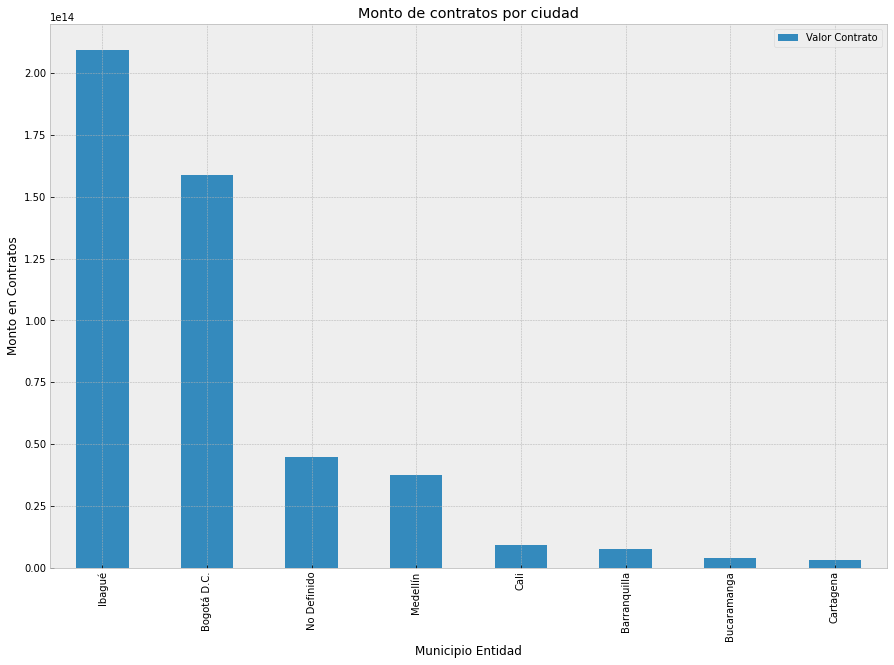

In [260]:
sum_contratos = df_prep.groupby('Municipio Entidad').sum('Valor Contrato')
sum_contratos.reset_index().sort_values(by='Valor Contrato', ascending=False).plot(
    kind='bar', x='Municipio Entidad', y='Valor Contrato', 
    figsize=(15, 10), title='Monto de contratos por ciudad',  ylabel='Monto en Contratos')
plt.show()

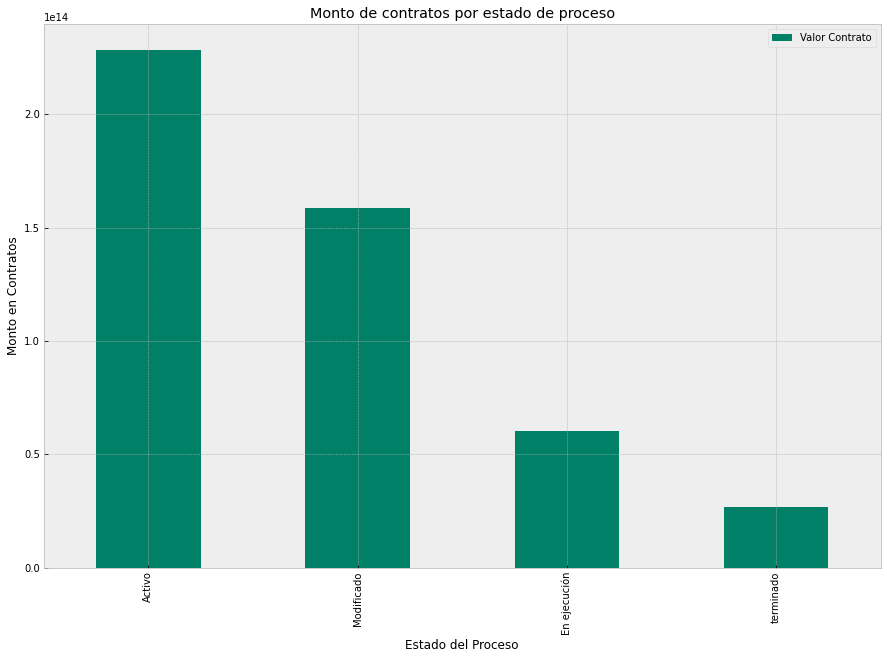

In [259]:
sum_contratos_proceso = df_prep.groupby('Estado del Proceso').sum('Valor Contrato')
sum_contratos_proceso.reset_index().sort_values(by='Valor Contrato', ascending=False).plot(
    kind='bar', x='Estado del Proceso', y='Valor Contrato', figsize=(15, 10), 
    title='Monto de contratos por estado de proceso', colormap='summer',  ylabel='Monto en Contratos')
plt.show()

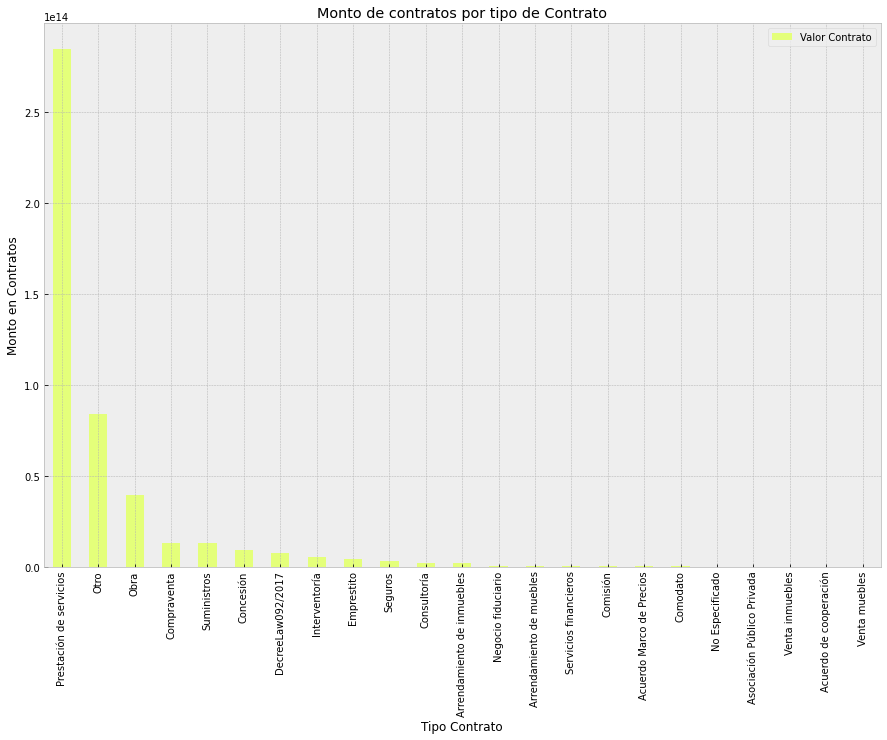

In [258]:
sum_contratos_proceso = df_prep.groupby('Tipo Contrato').sum('Valor Contrato')
sum_contratos_proceso.reset_index().sort_values(by='Valor Contrato', ascending=False).plot(
    kind='bar', x='Tipo Contrato', y='Valor Contrato', figsize=(15, 10), title='Monto de contratos por tipo de Contrato', colormap='Wistia', ylabel='Monto en Contratos')
plt.show()

In [267]:
df_mean_contrato = df_prep.groupby('Municipio Entidad').mean()['Valor Contrato']
df_mean_contrato.reset_index().sort_values(by='Valor Contrato', ascending=False)
df_mean_contrato = pd.DataFrame(df_mean_contrato)
df_mean_contrato

,Valor Contrato
Municipio Entidad,
Barranquilla,1.993558e+08
Bogotá D.C.,2.426675e+08
Bucaramanga,8.350261e+07
Cali,7.824744e+07
Cartagena,1.036053e+08
Ibagué,5.805189e+09
Medellín,4.728372e+08
No Definido,2.264826e+08


# Análisis de texto

In [269]:
!pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
from random import sample

In [26]:
len()

2000

In [276]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [53]:
columna = 'Objeto a Contratar'
texto_contratos = ''

for row in sample(list(df['Objeto a Contratar']), 1000):
  texto_contratos+=' '+row

In [44]:
texto_contratos

' Prestación de Servicios De Apoyo A La Gestión a la Subsecretaría De Política De Seguridad de la Secretaría de Seguridad y Justicia dentro del proyecto denominado Implementacion Seguimiento Y Evaluacion Del Plan Integral De Seguridad Y Convivencia Ciudadana En Santiago De Cali  Ficha EBI No BP26003248 Prestar servicios de apoyo a la gestión administrativa yo asistencial en el area de Enfermería dentro de los diferentes procesos y procedimientos de la SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE de acuerdo al requerimiento institucional Prestar sus servicios de apoyo a la gestión documental y catalogación de documentos que permitan  actualizar y recuperar el inventario material e inmaterial del patrimonio cultural CONTRATAR LA PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTIÓN DE UN MONITOR DEPORTIVO PARA LA ENSEÑANZA DE LA DISCIPLINA DEPORTIVA DE FUTBOL CON EL OBJETIVO DE DESARROLLAR LOS PROCESOS DE PROMOCIÓN Y MASIFICACIÓN DEL PROGRAMA CENTROS DE DESARROLLO DEPORTIVO EN EL MAR

In [47]:
stopwords_list = stopwords.words('spanish') + ['DE', 'de', 'PARA', 'LA', 'los', 'Y', 'LO', 'EL']

In [54]:
texto_contratos = ' '.join([x for x in texto_contratos.strip().lower().split(' ') if x not in stopwords_list and len(x)>5])

In [55]:
texto_contratos

'contratar compraventa dotación vestido calzado establecidos funcionaria contraloría general quindío prestacion servicios profesionales asesoría externa asuntos jurídicos administrativos desarrollen competencia secretaria general desarrollo institucional adquirir mediante suministro dispositivos médicos administración segura medicamentos partir contrato comodato bombas infusión suscrito prestación servicios personales realizar actividades organización archivos gestión archivo central fondos documentales acumulados central direcciones territoriales unidades operativas catastro conforme directrices establecidas programa gestión documental normas emitidas archivo general nación prestar servicios profesionales apoyar dirección información tecnología subdirecciones operación tecnológica implementación proyectos monitoreo sostenibilidad continuidad modelo seguridad privacidad información seguridad digital continuidad operación regional bogota conexas prestar servicios periodísticos través di

In [36]:
from wordcloud import WordCloud

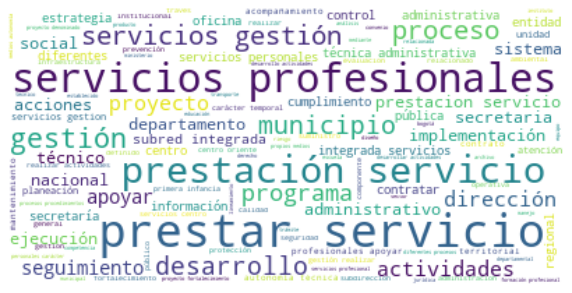

In [57]:
wc = WordCloud(background_color='white')
wc.generate(texto_contratos)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

# Modelamiento

## Aprendizaje supervisado: Predicción de valor de contrato

In [61]:
data = df_prep.copy()

for i, columns in enumerate(list([str(d) for d in data.dtypes])):
  if columns=='object':
    data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
    data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
  else:
    data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [62]:
data.head()

,Nombre de la Entidad,Estado del Proceso,Objeto a Contratar,Valor Contrato,Municipio Entidad,Tipo Contrato
0,1003,2,517621,26644129,1,17
1,530,1,207614,5400000,3,17
2,798,2,51968,48230400,1,17
3,917,1,356877,9840000,3,17
4,400,2,463029,31075147,1,17


In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score

In [67]:
X = data.copy().drop('Valor Contrato', axis=1)
y = data.pop('Valor Contrato')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)

In [72]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [74]:
r2_score(y_true=y_test, y_pred=clf.predict(X_test))

-1.2479366378124377

## No supervisado: Agrupamiento de texto

In [76]:
import gensim
np.random.seed(2022)

In [78]:
def preprocess(text):
  result = []
  for token in text.split():
    if token not in stopwords.words('spanish') and len(token)>4:
      result.append(token)
  return result

In [102]:
caracteristica = pd.Series(sample(list(df_prep['Objeto a Contratar'].apply(lambda x: x.lower())), 10000))

In [103]:
process_grupos = [preprocess(x) for x in list(caracteristica.unique())] 

In [104]:
dictionary = gensim.corpora.Dictionary(process_grupos)
dictionary.filter_extremes(no_below=1, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in process_grupos]

In [105]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [106]:
for idx, mun in lda_model.print_topics(-1):
  print('Topic:{} Words{}'.format(idx, mun))

Topic:0 Words0.016*"mantenimiento" + 0.011*"prestacion" + 0.011*"municipio" + 0.009*"profesionales" + 0.009*"suministro" + 0.008*"esfuerzos" + 0.008*"aunar" + 0.008*"preventivo" + 0.007*"correctivo" + 0.007*"apoyo"
Topic:1 Words0.040*"prestar" + 0.030*"gestión" + 0.026*"profesionales" + 0.022*"apoyo" + 0.021*"administrativa" + 0.018*"actividades" + 0.014*"técnica" + 0.014*"procesos" + 0.013*"salud" + 0.010*"autonomía"
Topic:2 Words0.015*"prestar" + 0.014*"integral" + 0.012*"desarrollo" + 0.012*"marco" + 0.011*"infancia" + 0.010*"primera" + 0.009*"profesionales" + 0.008*"apoyar" + 0.008*"atención" + 0.007*"servicio"
Topic:3 Words0.036*"profesionales" + 0.028*"prestar" + 0.019*"apoyar" + 0.017*"gestión" + 0.013*"dirección" + 0.013*"actividades" + 0.012*"seguimiento" + 0.012*"prestación" + 0.010*"desarrollo" + 0.009*"control"
Topic:4 Words0.019*"prestación" + 0.017*"prestar" + 0.014*"profesionales" + 0.014*"apoyo" + 0.013*"gestión" + 0.012*"formación" + 0.012*"integral" + 0.012*"atención"

In [107]:
def get_max(index):
  results = lda_model[bow_corpus[index]]
  return max(lda_model[results], key=lambda x: x[1])[0]

In [108]:
grupos = {x: get_max(i) for i, x in enumerate(list(caracteristica.unique()))}

In [109]:
grupos

{'apoyar en materia jurídica y administrativa los proyectos de la unidad administrativa especial de aeronáutica civil para el mejoramiento de los servicios aeroportuarios y a la navegación aérea': 1,
 'prestar desde su perfil profesional sus servicios para apoyar a la unidad técnica territorial no 10 en los procesos de diagnóstico estructuración formulación ejecución de los proyectos integrales de desarrollo agropecuario y rural con enfoque territorial de acuerdo con los procedimientos establecidos para este fin asi como en el acompañamiento en el proceso de habilitación de epseas y el seguimiento desde su perfil profesional a las actividades que se desarrollan con las asociaciones de usu': 0,
 'servicio anual de rastreo y seguimiento satelital para los equipos de localización satelital spot gen3': 1,
 'prestar los servicios personales de carácter temporal para impartir formación profesional integral mediante la modalidad de periodos fijos de instructores para la ejecución de acciones 

In [110]:
df_prep['Grupo'] = caracteristica.apply(lambda x: grupos[x])

In [ ]:
df_prep.head()

In [111]:
df_prep['Grupo'].head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: Grupo, dtype: float64

In [112]:
df_prep['Grupo'].value_counts(normalize=True)

0.0    0.786354
1.0    0.106334
3.0    0.102263
2.0    0.005048
Name: Grupo, dtype: float64

[]

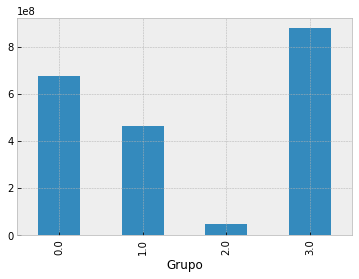

In [113]:
df_prep.groupby('Grupo')['Valor Contrato'].mean().plot.bar()
plt.plot()

## No supervisado: Detección de anomalías

In [114]:
from scipy.stats import norm

In [115]:
params = norm.fit(df_prep['Valor Contrato'])

In [116]:
params

(395526266.7543602, 188270681837.48502)

In [120]:
df_prep['Probabilidad'] = [norm(params[0], params[1]).cdf(x) for x in df_prep['Valor Contrato']]

In [121]:
df_prep[df_prep['Probabilidad']>0.95]

,Nombre de la Entidad,Estado del Proceso,Objeto a Contratar,Valor Contrato,Municipio Entidad,Tipo Contrato,Grupo,Probabilidad
8475,INSTITUTO NACIONAL DE VIAS,En ejecución,MEJORAMIENTO MEDIANTE LA CONSTRUCCIÓN Y MANTEN...,630007748262,Bogotá D.C.,Obra,0.0,0.999587
18763,INSTITUTO DE INFRAESTRUCTURA Y CONCESIONES DE ...,En ejecución,En virtud del presente Contrato y bajo los tér...,400000000000,Bogotá D.C.,Emprestito,NaN,0.983102
32071,INSTITUTO NACIONAL DE VIAS,Modificado,MEJORAMIENTO Y MANTENIMIENTO GESTIÓN PREDIAL S...,362262905449,Bogotá D.C.,Obra,NaN,0.972701
40135,SENA DIRECCIÓN GENERAL Dirección Jurídica,Modificado,CONTRATAR LA PRESTACIÓN DE SERVICIOS INTEGRALE...,806579942097,Bogotá D.C.,Prestación de servicios,NaN,0.999991
90017,INSTITUTO NACIONAL DE VIAS,Modificado,MEJORAMIENTO MANTENIMIENTO GESTIÓN PREDIAL SOC...,406967087388,Bogotá D.C.,Obra,NaN,0.984595
...,...,...,...,...,...,...,...,...
1873900,DIRECCIÓN GENERAL DE SANIDAD MILITAR,Modificado,PRESTACIÓN DE SERVICIOS DE SALUD A TRAVES DE U...,332053384139,No Definido,Otro,NaN,0.960932
1912148,INSTITUTO COLOMBIANO DE BIENESTAR FAMILIAR SED...,En ejecución,PRODUCCIÓN DE ALIMENTOS DE ALTO VALOR NUTRICIO...,1107899489590,No Definido,Prestación de servicios,NaN,1.000000
1923153,ARMADA NACIONAL BASE NAVAL No 6 ARC BOGOTA,Modificado,SERVICIOS DE MANTENIMIENTO PROGRAMADOS IMPREVI...,3482943972000,Bogotá D.C.,Otro,NaN,1.000000
1986368,MINISTERIO DE SALUD Y PROTECCIÓN SOCIAL,Modificado,Aunar esfuerzos técnicos administrativos y fin...,599971286503,Bogotá D.C.,Otro,NaN,0.999275


In [129]:
models_sheet = {}

for sheet in list(df_prep['Nombre de la Entidad'].unique()):
  sheet_entidad = df_prep[df_prep['Nombre de la Entidad']==sheet]
  params = norm.fit(sheet_entidad['Valor Contrato'])
  models_sheet[sheet]=norm(params[0], params[1])


In [130]:
models_sheet

{'SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b22d512b0>,
 'GOBERNACION DEL VALLE DEL CAUCA  DADI': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b27447a60>,
 'MINISTERIO DE SALUD Y PROTECCIÓN SOCIAL': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b1532e550>,
 'SANTIAGO DE CALI DISTRITO ESPECIAL   SECRETARIA DE EDUCACION DE CALI': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b27447c70>,
 'ESAP SEDE CENTRAL Cuenta Oficial': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b282263a0>,
 'RUTA N MEDELLIN': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b22d51d90>,
 'INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD  IDIPRON': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b29ee9220>,
 'INSTITUCION UNIVERSITARIA ITSA': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f9b2a41ae50>,
 'SANTIAGO DE CALI  DISTRITO ESPECIAL  SECRETARIA DE CULTURA': <scipy.stats._distn_infrast

In [133]:
sheet_prob = []

for i, row in df_prep.iterrows():
  sheet_prob.append(models_sheet[row['Nombre de la Entidad']].cdf(row['Valor Contrato']))
df_prep['Prob entidad'] = sheet_prob

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning:

invalid value encountered in double_scalars



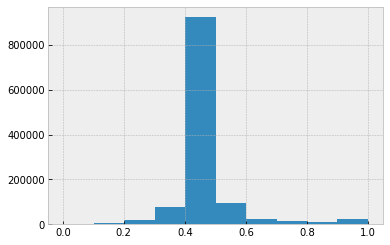

In [134]:
df_prep['Prob entidad'].hist()
plt.show()

In [138]:
df_prep[df_prep['Prob entidad']>0.9999]

,Nombre de la Entidad,Estado del Proceso,Objeto a Contratar,Valor Contrato,Municipio Entidad,Tipo Contrato,Grupo,Probabilidad,Prob entidad
72,ESAP SEDE CENTRAL Cuenta Oficial,Modificado,Prestar servicios para apoyar el desarrollo de...,7802190159,Bogotá D.C.,Prestación de servicios,0.0,0.515691,1.000000
245,ESTABLECIMIENTO PUBLICO AMBIENTAL BARRANQUILLA...,Activo,PRESTACIÓN DE SERVICIOS PARA LA OPERACIÓN LOGÍ...,194500000,Barranquilla,Prestación de servicios,0.0,0.499574,1.000000
382,ICBF REGIONAL ATLANTICO,terminado,Aunar esfuerzos y recursos técnicos administra...,97461908682,Barranquilla,Otro,3.0,0.696922,1.000000
401,INSTITUTO COLOMBIANO AGROPECUARIO ICA,En ejecución,CONTRATAR EL SERVICIO DE CENTRO DE OPERACIONES...,1999760000,Bogotá D.C.,Otro,0.0,0.503399,1.000000
569,DISPENSARIO MEDICO DE BUCARAMANGA,En ejecución,PRESTACIÓN DE SERVICIOS DE SALUD DE SALUD DE I...,1000000000,No Definido,Otro,0.0,0.501281,1.000000
...,...,...,...,...,...,...,...,...,...
1994865,CENTRO DE DIAGNOSTICO AUTOMOTOR DEL VALLE LIMI...,Modificado,PRESTAR EL SERVICIO DE MANTENIMIENTO PREVENTIV...,711699265,Cali,Prestación de servicios,NaN,0.500670,0.999980
1994986,INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE,Modificado,CONTRATAR LA PRESTACIÓN DEL SERVICIO INTEGRAL ...,43420703630,Bogotá D.C.,Prestación de servicios,NaN,0.590382,1.000000
1995415,HOSPITAL MILITAR CENTRAL,Modificado,PRESTACIÓN DE SERVICIOS PROFESIONALES PARA EL ...,11469928615,Bogotá D.C.,Prestación de servicios,NaN,0.523453,0.999999
1995594,ALCALDIA LOCAL DE KENNEDY,Modificado,AUNAR ESFUERZOS TÉCNICOS ADMINISTRATIVOS Y FIN...,10157035450,No Definido,Otro,NaN,0.520675,1.000000


---
*Let’s change the world, Together!*


<img align=centerright src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F202df933-5432-47f6-aba6-a9a054cece4b%2Fpages-PhotoRoom.png?table=block&id=0b1ffffe-7be4-41f2-86dd-26cad410a64b&spaceId=12eea25e-0790-4a8f-aa1c-b60f93c02da2&width=250&userId=4be5c684-7292-494e-bbb2-2554f1af3879&cache=v2"  width="70" height="70">

<img align=centerright src="https://cdn-icons-png.flaticon.com/512/25/25231.png"  width="70" height="70">
<img align=centerright src="https://cdn-icons-png.flaticon.com/512/61/61109.png?w=360"  width="70" height="70">
<img align=centerright src="https://cdn-icons-png.flaticon.com/512/39/39552.png"  width="70" height="70">
<img align=centerright src="https://cdn.freebiesupply.com/images/large/2x/instagram-icon-white-on-black.png"  width="100" height="70">

[Personal Blog](https://santiagoal.super.site/)      [GitHub](https://github.com/santiagoahl)    [LinkedIn](https://www.linkedin.com/in/santiago-ahumada-lozano/)   [Twitter](https://twitter.com/sahumadaloz)  [Instagram](https://www.instagram.com/santiago_al10/)
